In [1]:
import faraway.datasets.galapagos
import faraway.utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

## 2. Testing Examples

In [2]:
galapagos = faraway.datasets.galapagos.load()
galapagos.head()

,Species,Area,Elevation,Nearest,Scruz,Adjacent
Baltra,58,25.09,346,0.6,0.6,1.84
Bartolome,31,1.24,109,0.6,26.3,572.33
Caldwell,3,0.21,114,2.8,58.7,0.78
Champion,25,0.10,46,1.9,47.4,0.18
Coamano,2,0.05,77,1.9,1.9,903.82


In [3]:
lmod = smf.ols(
    'Species ~ Area + Elevation + Nearest + Scruz + Adjacent',
    galapagos
).fit()
lmod.fvalue, lmod.f_pvalue

(15.699412204831022, 6.837892995112339e-07)

In [4]:
lmodr = smf.ols('Species ~ 1', galapagos).fit()
lmod.compare_f_test(lmodr)

(15.699412204831022, 6.837892995112339e-07, 5.0)

In [5]:
lmod.centered_tss, lmod.ssr

(381081.36666666664, 89231.36633005121)

In [6]:
lmod.df_model, lmod.df_resid

(5.0, 24.0)

In [7]:
lmod.mse_model, lmod.mse_resid

(58370.00006732308, 3717.973597085467)

In [8]:
F = lmod.mse_model / lmod.mse_resid
F

15.699412204831022

In [9]:
p = 1 - sp.stats.f.cdf(lmod.fvalue, lmod.df_model, lmod.df_resid)
p

6.837892995159578e-07

### Testing One Predictor

In [10]:
lmods = smf.ols(
    'Species ~ Elevation + Nearest + Scruz + Adjacent', galapagos
).fit()
sm.stats.anova_lm(lmods, lmod)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,25.0,93469.08399,0.0,NaN,NaN,NaN
1,24.0,89231.36633,1.0,4237.71766,1.139792,0.296318


In [11]:
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Species   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     15.70
Date:                Sun, 22 May 2022   Prob (F-statistic):           6.84e-07
Time:                        19:49:20   Log-Likelihood:                -162.54
No. Observations:                  30   AIC:                             337.1
Df Residuals:                      24   BIC:                             345.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0682     19.154      0.369      0.715     -32.464      46.601
Area          -0.0239      0.022     -1.068      0.296      -0.070       0.022
Elevation      0.3195      0.054      5.953      0.000       0.209       0.430
Nearest        0.0091      1.054      0.009      0.993      -2.166       2.185
Scruz         -0.2405      0.215     -1.117      0.275      -0.685       0.204
Adjacent      -0.0748      0.018     -4.226      0.000      -0.111      -0.038
==============================================================================
Omnibus:                       12.683   Durbin-Watson:                   2.476
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.498
Skew:                           1.136   Prob(JB):                      0.00117
Kurtosis:                       5.374   Cond. No.                     1.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Testing a Pair of Predictors

In [12]:
lmods = smf.ols(
    'Species ~ Elevation + Nearest + Scruz', galapagos
).fit()
sm.stats.anova_lm(lmods, lmod)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,26.0,158291.628568,0.0,NaN,NaN,NaN
1,24.0,89231.366330,2.0,69060.262238,9.287352,0.00103


### Testing a Subspace

In [13]:
lmods = smf.ols(
    'Species ~ I(Area + Adjacent) + Elevation + Nearest + Scruz',
    galapagos
).fit()
sm.stats.anova_lm(lmods, lmod)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,25.0,109591.120801,0.0,NaN,NaN,NaN
1,24.0,89231.366330,1.0,20359.754471,5.476035,0.027926


(i.e., the simplification of combining Area & Adjacent not justified)

In [14]:
# Test if  coef of Elevation is a specific value (0.5)
lmod = smf.glm(
    'Species ~ Area + Elevation + Nearest + Scruz + Adjacent',
    galapagos
).fit()
lmods = smf.glm(
    'Species ~ Area + Nearest + Scruz + Adjacent',
    offset=(0.5 * galapagos.Elevation),
    data=galapagos
).fit()
fstat = (
    (lmods.deviance - lmod.deviance) / (lmod.deviance / lmod.df_resid))
p = 1 - sp.stats.f.cdf(fstat, 1, lmod.df_resid)
fstat, p

(11.318196837955558, 0.002573836486092773)

(reject hypothesis: Beta[elev] = 0.5)

In [15]:
# More simply
HYPOTH = 0.5
lmod = smf.glm(
    'Species ~ Area + Elevation + Nearest + Scruz + Adjacent',
    galapagos
).fit()
tstat = (lmod.params['Elevation'] - HYPOTH) / lmod.bse['Elevation']
p = 2 * sp.stats.t.cdf(tstat, lmod.df_resid)
tstat, p

(-3.364252790435871, 0.002573836486092733)

## 3. Permutation Tests

In [16]:
lmod = smf.ols('Species ~ Nearest + Scruz', galapagos).fit()
N_PERM = 4000
f_stats = np.zeros(N_PERM)
for i in range(N_PERM):
    galapagos['ysamp'] = np.random.permutation(galapagos.Species.copy())
    lmodi = smf.ols('ysamp ~ Nearest + Scruz', galapagos).fit()
    f_stats[i] = lmodi.fvalue

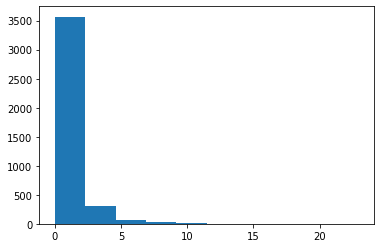

In [17]:
plt.hist(f_stats);

In [18]:
p_est = np.mean(f_stats > lmod.fvalue)
p_est  # est p val of mod as a whole

0.55375

In [19]:
# Scruz:
lmod.tvalues[2], lmod.pvalues[2]

(-1.0946730850617026, 0.2833295186486556)

In [20]:
t_stats = []
for i in range(N_PERM):
    galapagos['ssamp'] = np.random.permutation(galapagos.Scruz)
    lmodi = smf.ols('Species ~ Nearest + ssamp', galapagos).fit()
    t_stats.append(lmodi.tvalues[2])

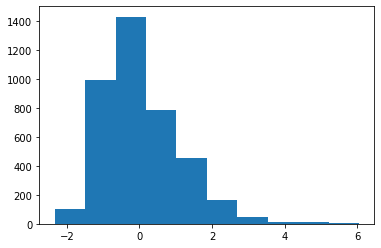

In [21]:
plt.hist(t_stats);

In [22]:
p_scruz = np.mean(np.fabs(t_stats) > np.fabs(lmod.tvalues[2]))
p_scruz

0.26825

## 5. Confidence Intervals for β

In [23]:
lmod = smf.ols(
    'Species ~ Area + Elevation + Nearest + Scruz + Adjacent',
    galapagos
).fit()
qt = np.array(sp.stats.t.interval(0.95, 24))  # 24 = df
ci_area = lmod.params[1] + lmod.bse[1] * qt
ci_area

array([-0.0702158 ,  0.02233912])

In [24]:
ci_adjacent = lmod.params[5] + lmod.bse[5] * qt
ci_adjacent

array([-0.11133622, -0.03827344])

In [25]:
lmod.conf_int()

,0,1
Intercept,-32.464101,46.600542
Area,-0.070216,0.022339
Elevation,0.208710,0.430219
Nearest,-2.166486,2.184774
Scruz,-0.685093,0.204044
Adjacent,-0.111336,-0.038273


## 6. Bootstrap Confidence Intervals

In [26]:
reps = 4000
coef_mat = np.empty((reps, 6))
resids = lmod.resid
preds = lmod.predict()
for i in range(reps):
    galapagos['y_samp'] = preds + np.random.choice(resids, 30)
    lmodi = smf.ols(
        'y_samp ~ Area + Elevation + Nearest + Scruz + Adjacent',
        galapagos
    ).fit()
    coef_mat[i, :] = lmodi.params
coef_mat = pd.DataFrame(
    coef_mat, 
    columns=(
        'intercept', 'area', 'elevation', 'nearest', 'scruz', 'adjacent'
    ))
coef_mat.quantile((0.025, 0.975))

,intercept,area,elevation,nearest,scruz,adjacent
0.025,-24.516966,-0.062224,0.230978,-1.684418,-0.593421,-0.105012
0.975,42.375954,0.019256,0.419410,2.054996,0.179466,-0.040350


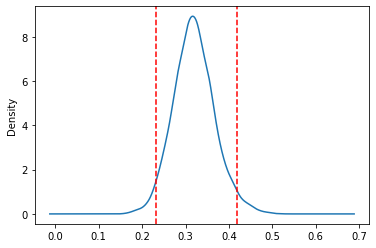

In [31]:
coef_mat.elevation.plot.density()
xci = coef_mat.elevation.quantile((0.025, 0.975)).ravel()
plt.axvline(x=xci[0], linestyle='--', color='r')
plt.axvline(x=xci[1], linestyle='--', color='r');

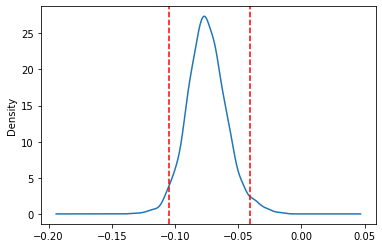

In [32]:
coef_mat.adjacent.plot.density();
xci = coef_mat.adjacent.quantile((0.025, 0.975)).ravel()
plt.axvline(x=xci[0], linestyle='--', color='r')
plt.axvline(x=xci[1], linestyle='--', color='r');